In [1]:
using Revise
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
using Statistics
import ProgressMeter
using Optim

In [2]:
data_seed, params_seed = 42, 120

(42, 120)

In [3]:
import ReactiveMP.messageout

In [4]:
include("../helpers/data.jl")

generate_data

In [5]:
function NN(y_,u_,θ)
    W1, b1 = reshape(θ[1:10],(5,2)), θ[11:15]
    W2, b2 = θ[16:20], θ[end]
    x = tanh.(W1*[y_;u_] .+ b1)
    W2'x + b2
end

melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [6]:
melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [28]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    
    dim = length(h_prior[1])

    # Extract parameters for flow, neural network and Gamma
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end] # TODO: fix
    
    # initialize variables
    h       = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))}  
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(w_prior[1], w_prior[2]))}
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    neural_out = [NN(y_prev[i], u[i], params_f) for i in 1:n] #TODO: fix

    # create meta for AR
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        y_lat_1[t] ~ Flow(h[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dim))
        y_lat_3[t] ~ y_lat_2[t] + neural_out[t]
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_3[t], w)
        h_prev = h[t]
    end

    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [224]:
function nonlinear_max_inference(observations, observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(zeros(2), 0.1*diageye(2)), w_prior=(1.0, 1.0), vmp_its=1)
    # fetch number of samples
    n = length(observations)
    params_w = params[end-1:end]

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes) = nonlinear_max(n, model_flow, params[1:end-2], h_prior,
                                                                            w_prior, observations_prev, controls,
                                                                            options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(melu(params_w[1]), melu(params_w[2])))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), diageye(dim)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [225]:
# specify flow model
dim = 2
model_flow = FlowModel(dim,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [226]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
order_y, order_u, order_e = 2, 2, 2
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_e),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [227]:
observations_prev = y_obs[1:end-1]
observations      = y_obs[2:end];
controls          = u[order_u:end];

In [228]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

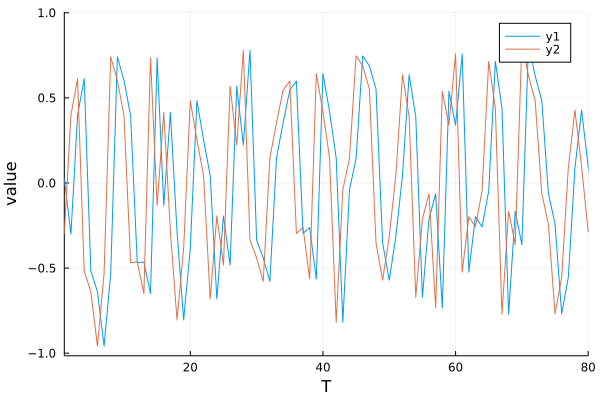

In [229]:
from, to = 1, 80
plot(X_train, xlims=(1, train_size))
plot!(Y_train, xlims=(from, to), xlabel="T", ylabel="value")

In [230]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
NN_param_len = 21
all_params = [randn(flow_param_len+NN_param_len); [10, 10]]; #Flow, NN, Gamma

In [231]:
fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, all_params, vmp_its=5);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


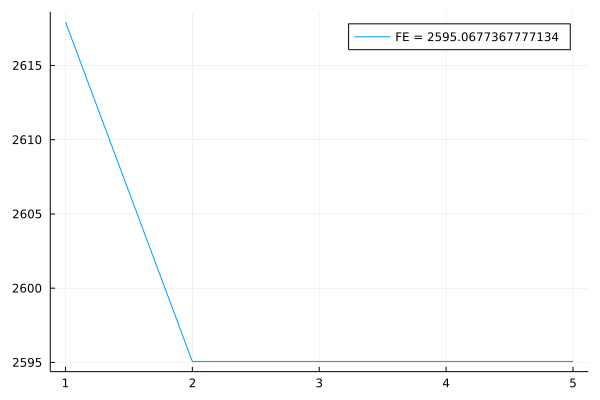

In [232]:
gr()
plot(fe, label="FE = $(fe[end])")

In [233]:
# Optimization function
function FE(params)
    fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, 
                                                 h_prior=(zeros(2), 0.001*diageye(2)), 
                                                 vmp_its=1)
    return fe[end]
end;

In [234]:
FE(all_params)

2622.411716216282

In [235]:
# unpack if you don't want to run Optim
@unpack inf_params = JLD.load("../dump/flow_nn_dataseed_$(data_seed)_paramsseed_$(params_seed).jld")

Dict{String, Any} with 1 entry:
  "inf_params" => [0.424182, -0.544779, 0.674359, -1.71439, 0.589744, 0.981843,…

In [236]:
res = optimize(FE, all_params, GradientDescent(), Optim.Options(g_tol = 1e-12, iterations = 1000, store_trace = true, show_trace = true, show_every=10), autodiff=:forward)


Iter     Function value   Gradient norm 
     0     2.622412e+03     8.379302e+02
 * time: 9.107589721679688e-5
    10     1.815047e+03     1.264042e+02
 * time: 21.743560075759888
    20     1.751439e+03     1.078126e+02
 * time: 42.3858060836792
    30     1.550801e+03     6.639205e+01
 * time: 67.86399698257446
    40     1.521641e+03     5.236126e+01
 * time: 90.13692808151245
    50     1.501225e+03     4.116106e+01
 * time: 110.54885292053223
    60     1.488909e+03     2.844330e+01
 * time: 130.94934797286987
    70     1.481594e+03     2.851181e+01
 * time: 150.52533102035522
    80     1.476302e+03     3.240139e+01
 * time: 169.88741993904114
    90     1.472193e+03     3.475413e+01
 * time: 189.3938159942627
   100     1.468750e+03     3.491673e+01
 * time: 209.29646396636963
   110     1.465709e+03     3.366783e+01
 * time: 229.4165370464325
   120     1.462918e+03     3.161438e+01
 * time: 250.2844910621643
   130     1.460318e+03     3.105416e+01
 * time: 271.5117330551147

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.333986e+03

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 3.64e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.90e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.42e-02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.81e-05 ≰ 0.0e+00
    |g(x)|                 = 8.65e+01 ≰ 1.0e-12

 * Work counters
    Seconds run:   2014  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    2825
    ∇f(x) calls:   2825


In [237]:
inf_params = Optim.minimizer(res)

32-element Vector{Float64}:
  2.3988269734271883
 -1.490673560417128
 -0.006320821487185406
 -1.6256131143240926
  1.63392620840336
 -0.000626626984467016
  2.4154927529920776
 -0.6223194162420754
  0.0013315053906495116
 -0.4414537167551543
 -0.38216938544206674
  0.48851659072003784
  1.7791059604201287
  ⋮
 -0.8515551575236889
  0.22571991459598106
  1.283261289061569
 -0.9729251089472437
 -0.42548878879514423
  0.4731275576630311
  0.7678969169221296
  0.2704451814011907
 -0.5280422423265699
 -0.36609523612309214
  6.531581733642367
 12.546874103171781

In [238]:
using JLD
JLD.save("../dump/flow_nn_mle_dataseed_$(data_seed)_paramsseed_$(params_seed).jld", "inf_params", inf_params)

In [239]:
FE(inf_params)

1333.9871173404335

In [240]:
fe_inf, h_inf, w_inf, y_out_inf, θ_inf = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, vmp_its=10);


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


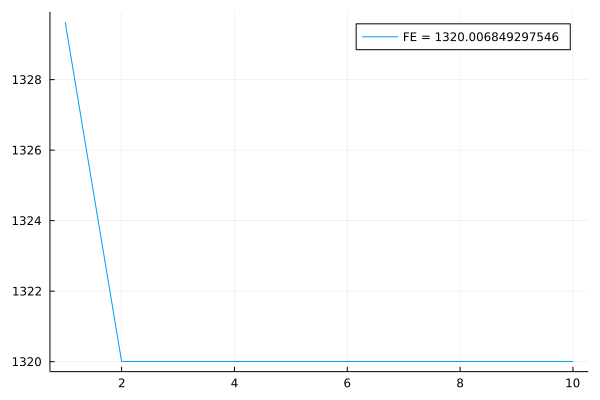

In [241]:
plot(fe_inf[1:end], label="FE = $(fe_inf[end])")

In [242]:
from, to = 100, 150

(100, 150)

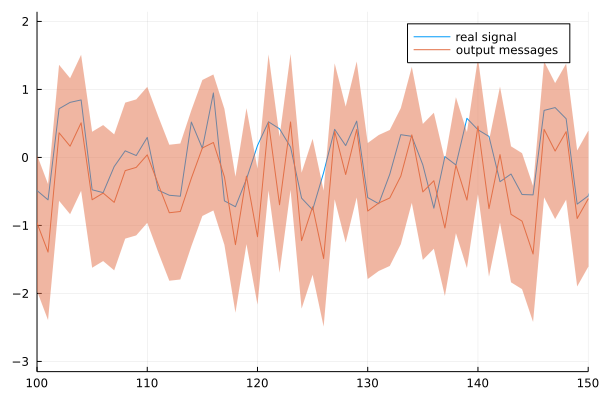

In [243]:
my, vy = mean.(y_out), cov.(y_out)
plot(Y_train, xlims=(from, to), label="real signal")
plot!(my, ribbon=sqrt.(vy), label="output messages")

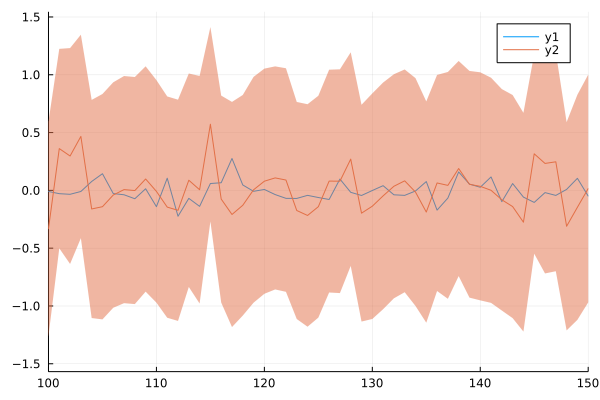

In [244]:
mh, vh = mean.(h_inf), cov.(h_inf)
plot(h_gen)
plot!(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(from, to))

### KF-like prediction

In [245]:
function transition(γ, order)
    V = zeros(order, order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [246]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction(model_flow::FlowModel, params, w, h_prior, y_prev, u)
    
    dim = length(h_prior[1])

    A = shift(dim) # transition matrix
    V = transition(w, dim)

    # initialize variables
    y_pred   = datavar(Float64)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]

    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    NN_pred = NN(y_prev, u, params_f)

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}
    
    y_lat_1 ~ Flow(h) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(dim))
    
    y_lat_3 ~ y_lat_2 + NN_pred

    y_node, y ~ NormalMeanPrecision(y_lat_3, w) where { q = q(y, y_lat_3)q(w)}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred
end

nonlinear_max_prediction (generic function with 2 methods)

In [247]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 1) where T<:Float64

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred) = nonlinear_max_prediction(model_flow, params, w, h_prior,
                                                                                                    observation_prev, control,
                                                                                                    options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 2 methods)

In [248]:
predictions = []
h_prev = (mean(h_inf[end]), precision(h_inf[end]))
ŵ = inf_params[end-1]/inf_params[end]
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction(X_test[i], U_test[i], model_flow, inf_params, h_prior=h_prev, w=ŵ, vmp_its=1)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, h_prior=h_prev, vmp_its=1);
    h_prev = (mean.(h_inf)[1], precision.(h_inf)[1])
end

In [249]:
mx, vx = mean.(predictions), cov.(predictions)

([0.10114729967455038, 0.05384402469094781, -0.38365551498614225, -0.12356438780881715, -0.024614294047063955, 0.42199183526233613, 0.18978216123605643, -0.057813793611119366, -0.29773701826032506, -0.26486167332829486  …  -0.2002877908774927, -0.05673343872153553, -0.036566826687454944, 0.11523755864118487, 0.06461870458482599, 0.1589185246122799, 0.03320084852370615, -0.09080506215620363, -0.06843069906411214, 0.4158199606657917], [1.9548870007112409, 1.9850967601745393, 1.9955397889645192, 1.988693282125258, 1.9841790366689487, 1.9853123431755468, 1.9842486410344056, 1.9832475149323059, 1.9953943655959407, 1.9931232615793923  …  1.9932662882139098, 1.991106522984042, 1.9851006446214225, 1.9828015635634477, 1.985148904698438, 1.996641718311559, 1.9843877545919282, 2.0010545828874453, 1.9939961628181535, 1.9850081220090177])

In [250]:
test_from, test_to = 150, 200

(150, 200)

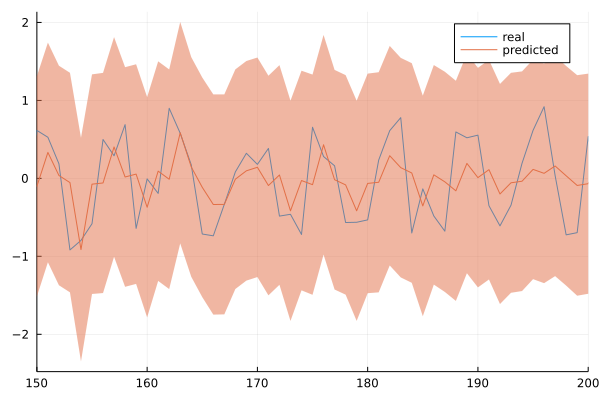

In [251]:
plot(Y_test, label="real")
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to), label="predicted")

In [252]:
n_output = [NN(y_prev, u, inf_params[13:end]) for (y_prev, u) in zip(X_test, U_test)]

201-element Vector{Float64}:
 16.048700830918552
 14.95753636470289
 25.874777460012893
 18.088790531902184
 17.944973498169613
 20.413824318365943
 16.397248977737195
 17.355110053690233
 27.46220858172821
 18.331770329728144
 18.075038543743
 18.057872556829448
 23.009348032754026
  ⋮
 15.765779731689094
 17.94243342701412
 20.215574104929836
 18.060219117412164
 17.91565183406067
 24.371911118129596
 15.574292588846362
 13.363994393810277
 24.490598121807963
 18.076541737061927
 18.08562292719089
 22.133336407934376

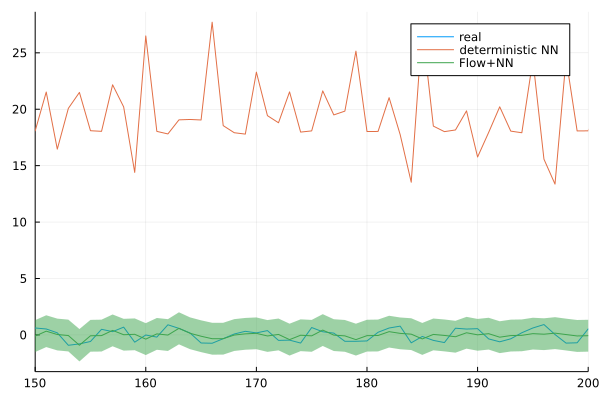

In [253]:
plot(Y_test, label="real")
plot!(n_output, label="deterministic NN")
plot!(mx, ribbon=sqrt.(vx), label="Flow+NN", xlims=(test_from, test_to))